<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/EVA4P2_S7_VAE_V5_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Thu Mar 11 13:19:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 17kB/s 
     |████████████████████████████████| 6.5MB 35.9MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.5.1+cu92 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu92


In [ ]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1393 (delta 5), reused 0 (delta 0), pack-reused 1376
Receiving objects: 100% (1393/1393), 180.69 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (743/743), done.
Checking out files: 100% (231/231), done.


In [ ]:
%cd '/content/Deep_Learning_EVA4_Phase2/S7_VAE'
! ls

/content/Deep_Learning_EVA4_Phase2/S7_VAE
 animation_vae_v1.mp4
 EVA4P2_S7_VAE_V5_KLD_batch_imgsize_no_Sigmoid_for_encoder_module.ipynb
'Model Weights'
 Readme_Content
 README.md
 src


In [ ]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S7_VAE/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import customdataset as cds
from src.dataset import Alb_data_transforms as Alb
from src.losses  import Train_Losses
from src.losses  import Test_Losses
from src.models  import VAE_Model as ntwk

In [ ]:
import torchvision.transforms as T
from typing import List, Tuple, Dict
from PIL import Image
from torchvision.transforms import Compose

In [ ]:
Mean: List = [0.48043839, 0.44820218, 0.39760034]
STD: List = [0.27698959, 0.26908774, 0.28216029]
TRANSFORMS: Compose = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),	
    T.Normalize(mean=Mean,std=STD),
    ])

In [ ]:
path_vae_img = '/content/gdrive/My Drive/EVA4P2_S7_Training/Car_Eval.jpg'
img = Image.open(f'{path_vae_img}') 
img = TRANSFORMS(img)
img.unsqueeze_(0)
img.shape

torch.Size([1, 3, 128, 128])

In [ ]:
img_cuda = img.cuda()
type(img_cuda)

torch.Tensor

In [ ]:
def weights_init_eval(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
IMAGE_DIM = (128, 128, 3)
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
VAE_Model = ntwk.VAE(IMAGE_DIM, in_channel=IMAGE_DIM[-1],out_channel=IMAGE_DIM[-1]).to(DEVICE)
VAE_Model.apply(weights_init_eval)

VAE(
  (encode): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): 

In [ ]:
VAE_prev_save = f'/content/gdrive/My Drive/EVA4P2_S7_Training/Model_Weights_D0922/VAE_GPU_1499_20200922095734.pt'
VAE_Model.load_state_dict(torch.load(VAE_prev_save))

<All keys matched successfully>

In [ ]:
VAE_Model.eval()
with torch.no_grad():
    reconstructed_img, mu, logvar  = VAE_Model(img_cuda)   
reconstructed_img.shape

torch.Size([1, 3, 128, 128])

In [ ]:
new_img = reconstructed_img.squeeze(0)
new_img.shape

torch.Size([3, 128, 128])

torch.Size([3, 128, 128])


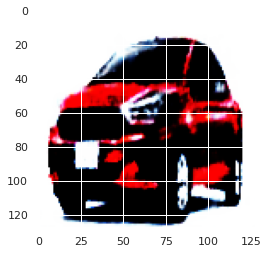

In [ ]:
display_img = new_img.cpu()
plt.imshow(display_img.permute(1, 2, 0))
print(display_img.shape)

In [ ]:
np_img = new_img.cpu().numpy()
np_img.shape

(3, 128, 128)

In [ ]:
np_img1 = np_img.transpose(2,1,0)
np_img1.shape

(128, 128, 3)

In [ ]:
np_img2 = Image.fromarray(np_img1, "RGB")

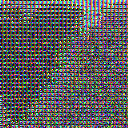

In [ ]:
np_img2

In [ ]:
img0 = cv2.cvtColor(np.float32(display_img.permute(1, 2, 0)), cv2.COLOR_RGB2BGR)

In [ ]:
img0 = img0[:, :, ::-1]

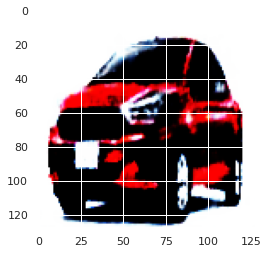

In [ ]:
plt.imshow(img0)

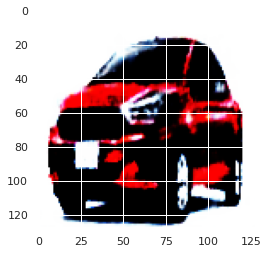

In [ ]:
img1 = display_img.permute(1, 2, 0)
#img1 = img1[:, :, ::-1]
plt.imshow(img1)

In [ ]:
np_img3 = np.array(display_img)

In [ ]:
np_img3.shape

(3, 128, 128)

In [ ]:
np_img4 = Image.fromarray(np_img3.transpose(2,1,0), "RGB")

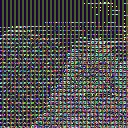

In [ ]:
np_img4